# Supervised Sentiment Analysis using Logistic Regression

Extracting Tf-Idf feature vector from the given movie review dataset and
Using Logistic Regression adn SGD algorithm to perform Supervised Sentiment Analysis

Libraries used:
1) Numpy - for numerical computations such as fft(), dot operator
2) Scipy - to find the likelihood of data points
3) Matplotlib - to plot the spectogram

In [168]:
import numpy as np
import string, re, random
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

### Function preprocess_text()

Gets the vocabulary of words from the given text dataset

Strips the sentences into individual words

In [169]:
vocabulary = []
target = []
words_count = []
reviews = []

def preprocess_text(filename):
    split_by_char =[':', '/']
    
    with open(filename, "r") as f:
        line_number = 0
        for line in f.readlines():
            review = []
            words = line.split(" ")

            word_count = 0
            for word in words[:-1]: 
                if word == "" or word == " " or word in string.punctuation:
                    continue

                word = word.strip(")(.*-&?:;, ")

                for char in split_by_char:
                    if char in word:
                        word2 = word.split(char)
                        for word in word2:
                            if word.lower() not in vocabulary:
                                vocabulary.append(word.lower())
                            word_count += 1
                            review.append(word.lower())
                else:
                    if word.lower() not in vocabulary:
                        vocabulary.append(word.lower())
                    review.append(word.lower())
                    word_count += 1
            line_number += 1

            words_count.append(word_count)
            if "0" in words[-1]:
                target.append(0)
                review.append(0)
            else:
                target.append(1)
                review.append(1)
            reviews.append(review)

In [170]:
preprocess_text("movieReviews1000.txt")
print("Number of unique words in vocabulary: ", len(vocabulary))

Number of unique words in vocabulary:  3165


#### Qs 5) a) Extracting Tf-Idf features per each word

### Function calculate_idf()

Calculates the Inverse Document Frequency values
for each word in the vocabulary

In [171]:
def calculate_idf(documents, vocabulary):
    
    idf = np.zeros((len(vocabulary), 1))
    
    n=len(documents)
    l = 0
    
    for word in vocabulary:
        word_count=0
        for words in documents:
            if word in words:
                word_count+=1
                
        idf[l]=(np.log((1+n)/(word_count+1)))
        l+=1
    return idf

### Function calculate_tf_idf()

Calculates the Term Frequency and Tf_Idf values
for each word and document in the given text dataset

In [172]:
def calculate_tf_idf(idf):
    tf_idf = np.zeros((len(vocabulary), 0))
    
    line = 0
    for review in reviews:
        tf =  np.zeros((len(vocabulary), 1))
        
        for word in review[:-1]:
            idx = vocabulary.index(word)
            tf[idx] += 1
        
        tf = (tf+1) / (2*len(review))
        line += 1
        tf_idf = np.hstack((tf_idf, tf))
    
    tf_idf_matrix = tf_idf * idf
    
    
    return tf_idf_matrix

In [173]:
idf = calculate_idf(reviews, vocabulary)
tf_idf = calculate_tf_idf(idf)
print("Size of the input feature matrix: ", tf_idf.shape)

Size of the input feature matrix:  (3165, 1000)


#### Qs 5) b) Performing PCA 

To reduce the dimension of the given data

In [174]:
from sklearn.decomposition import PCA

pca = PCA(n_components=30)

dim_red_tf_idf = pca.fit_transform(tf_idf.T)

print(dim_red_tf_idf.shape)

(1000, 30)


#### Test, Train and Validation data split

Train data = 600 samples  
Validation data = 100 samples  
Test data = 300 samples

In [175]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dim_red_tf_idf, target, test_size=0.3)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/7)

#### 5) c) Logistic Regression using Stochastic Gradient Descent

In [281]:
class LogisticRegression_SGD:
    
    def __init__(self, lr, epoch, bs):
        self.lr = lr
        self.epoch = epoch
        self.bs = bs

    # Define sigmoid function
    def sigmoid(self, z):
        sig = 1/(1 + np.exp(-z))
        return sig
    
    def calculate_loss(self, X):
        loss = 0
        for i in range(len(X)):
            y_n = self.sigmoid(np.dot(self.w.T, X[i]) + self.b)
            
            if y_n ==0 or y_n == 1:
                continue
                    
            loss += (y[i]*np.log(y_n)) + ((1 - y[i])*np.log(1-y_n))
                
        loss = loss * (-1/X.shape[0])
        return loss
        
    
    # Performing Logistic Regression with L2 Regularization
    def fit(self, X, y, X_val, y_val):
        
        print("======= Logistic Regression with BS = "+str(self.bs)+" and LR = "+str(self.lr)+" =======") 
        losses = []
        losses_val = []
        
        N = X.shape[0]
        
        # Initialize parameters
        self.w = np.random.rand(X.shape[1]) 
        self.b = 0
        
        for epoch in range(self.epoch):
            
            for i in range((N-1)//self.bs + 1):
                
                start_i = i*self.bs
                end_i = start_i + self.bs
                xb = X[start_i:end_i]
                yb = y[start_i:end_i]

                #  Compute gradient w.r.t 'w' 
                grdw = 1/self.bs * ((xb[i] * (yb[i] - self.sigmoid(np.dot(self.w.T, xb[i]) + self.b))))

                # Compute gradient w.r.t 'b'
                grdb = 1/self.bs * (yb[i] - self.sigmoid(np.dot(self.w.T, xb[i]) + self.b) )
                
                
                # Update parameters
                self.w = self.w + self.lr * grdw
                self.b = self.b + self.lr * grdb
                
            
            loss = self.calculate_loss(X)
            print("Epoch = ", epoch+1, " Training Loss = ", loss)
            losses.append(loss)

            loss = self.calculate_loss(X_val)
            #print("Epoch = ", epoch+1, " Validation Loss = ", loss)
            losses_val.append(loss)

        plt.plot([i for i in range(self.epoch)], losses, marker="o", color='g') 
        plt.plot([i for i in range(self.epoch)], losses_val, marker="o", color='b')
        plt.legend(['Training data', 'Validation data'])
        plt.xlabel('Epoch')
        plt.ylabel('Loss value')
        plt.title('Loss curve for BS='+str(self.bs)+ " and LR="+str(self.lr))
        plt.show()
        
    def predict(self, X, y):
        predictions = []
        for i in range(len(X)):
            z = np.dot(self.w, X[i]) + self.b
            y_pred = self.sigmoid(z)
            if y_pred>=0.5:
                predictions.append(1)
            else:
                predictions.append(0)
        acc = 0
        for i in range(len(predictions)):
            if predictions[i] == y[i]:
                acc+=1
        print("== Test Accuracy = ",acc/len(X)*100," % ==\n\n")
        


======= Logistic Regression with BS = 32 and LR = 0.1 =======
Epoch =  1  Training Loss =  1.2973002077805287
Epoch =  2  Training Loss =  0.7052791970804263
Epoch =  3  Training Loss =  0.70936855347746
Epoch =  4  Training Loss =  0.7095910370979058
Epoch =  5  Training Loss =  0.7099273005351625
Epoch =  6  Training Loss =  0.7102751631425133
Epoch =  7  Training Loss =  0.7106363403597459
Epoch =  8  Training Loss =  0.711010087003144
Epoch =  9  Training Loss =  0.7113957427374322
Epoch =  10  Training Loss =  0.7117926696131053
Epoch =  11  Training Loss =  0.7122002528319971
Epoch =  12  Training Loss =  0.7126178999830775
Epoch =  13  Training Loss =  0.7130450403340118
Epoch =  14  Training Loss =  0.7134811241393358
Epoch =  15  Training Loss =  0.7139256219661899
Epoch =  16  Training Loss =  0.714378024037531
Epoch =  17  Training Loss =  0.7148378395927261
Epoch =  18  Training Loss =  0.715304596265364
Epoch =  19  Training Loss =  0.7157778394781321
Epoch =  20  Training

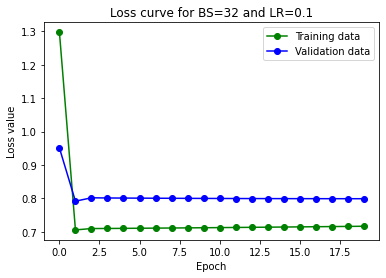

== Test Accuracy =  51.66666666666667  % ==


======= Logistic Regression with BS = 32 and LR = 0.01 =======
Epoch =  1  Training Loss =  3.5049323240549493
Epoch =  2  Training Loss =  3.3277869072075807
Epoch =  3  Training Loss =  3.1513259301339644
Epoch =  4  Training Loss =  2.975730212470491
Epoch =  5  Training Loss =  2.801167993288463
Epoch =  6  Training Loss =  2.627854817938809
Epoch =  7  Training Loss =  2.5161356373540835
Epoch =  8  Training Loss =  2.342548452361297
Epoch =  9  Training Loss =  2.170345835770174
Epoch =  10  Training Loss =  2.001002567218389
Epoch =  11  Training Loss =  1.835296546401428
Epoch =  12  Training Loss =  1.6741734988198451
Epoch =  13  Training Loss =  1.5188407906408392
Epoch =  14  Training Loss =  1.3708212965962487
Epoch =  15  Training Loss =  1.2319911822059724
Epoch =  16  Training Loss =  1.1045757409208858
Epoch =  17  Training Loss =  0.9910646418735815
Epoch =  18  Training Loss =  0.8940096579448693
Epoch =  19  Training Los

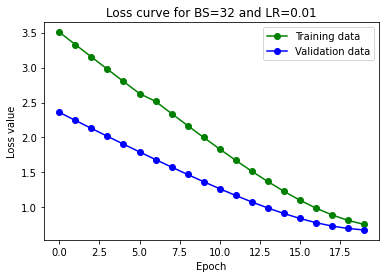

== Test Accuracy =  45.666666666666664  % ==


======= Logistic Regression with BS = 32 and LR = 0.001 =======
Epoch =  1  Training Loss =  2.8295689513066087
Epoch =  2  Training Loss =  2.812162698714916
Epoch =  3  Training Loss =  2.7947689585869475
Epoch =  4  Training Loss =  2.777387822145711
Epoch =  5  Training Loss =  2.7600194929136
Epoch =  6  Training Loss =  2.742664378747495
Epoch =  7  Training Loss =  2.7253226428771065
Epoch =  8  Training Loss =  2.7079945048949936
Epoch =  9  Training Loss =  2.6906803482341606
Epoch =  10  Training Loss =  2.6733803334165103
Epoch =  11  Training Loss =  2.656094843158332
Epoch =  12  Training Loss =  2.6388241047628185
Epoch =  13  Training Loss =  2.621568439903281
Epoch =  14  Training Loss =  2.6043281417419015
Epoch =  15  Training Loss =  2.5871035391467756
Epoch =  16  Training Loss =  2.569894934908705
Epoch =  17  Training Loss =  2.5527026696854604
Epoch =  18  Training Loss =  2.535527067876471
Epoch =  19  Training Loss

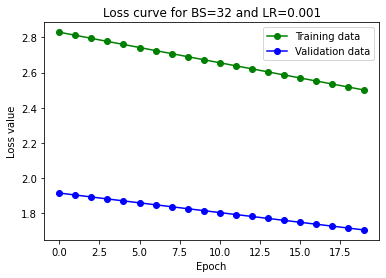

== Test Accuracy =  46.0  % ==


======= Logistic Regression with BS = 64 and LR = 0.1 =======
Epoch =  1  Training Loss =  1.7750411700286628
Epoch =  2  Training Loss =  1.5422552869350985
Epoch =  3  Training Loss =  1.3266058137908074
Epoch =  4  Training Loss =  1.1344206432895008
Epoch =  5  Training Loss =  0.972938708261839
Epoch =  6  Training Loss =  0.8486787811927451
Epoch =  7  Training Loss =  0.764870055469826
Epoch =  8  Training Loss =  0.7182810146010788
Epoch =  9  Training Loss =  0.6979782901378856
Epoch =  10  Training Loss =  0.6910696765889062
Epoch =  11  Training Loss =  0.6893613498758563
Epoch =  12  Training Loss =  0.6893231802547668
Epoch =  13  Training Loss =  0.689701397788571
Epoch =  14  Training Loss =  0.6901002895449782
Epoch =  15  Training Loss =  0.6904183981640126
Epoch =  16  Training Loss =  0.6906478349120332
Epoch =  17  Training Loss =  0.6908055787279455
Epoch =  18  Training Loss =  0.6909112439002016
Epoch =  19  Training Loss =  0.690

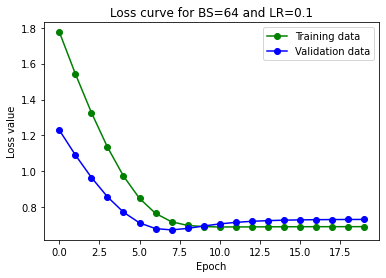

== Test Accuracy =  55.333333333333336  % ==


======= Logistic Regression with BS = 64 and LR = 0.01 =======
Epoch =  1  Training Loss =  2.5154836908003357
Epoch =  2  Training Loss =  2.4899039253725403
Epoch =  3  Training Loss =  2.4643735148823627
Epoch =  4  Training Loss =  2.4388937577087773
Epoch =  5  Training Loss =  2.4735387669970264
Epoch =  6  Training Loss =  2.4481644281833552
Epoch =  7  Training Loss =  2.422844952000131
Epoch =  8  Training Loss =  2.396426605184058
Epoch =  9  Training Loss =  2.3705456658212753
Epoch =  10  Training Loss =  2.3445486895975325
Epoch =  11  Training Loss =  2.3186810006234015
Epoch =  12  Training Loss =  2.292983878517673
Epoch =  13  Training Loss =  2.267446841995507
Epoch =  14  Training Loss =  2.2418488878701166
Epoch =  15  Training Loss =  2.216309772159338
Epoch =  16  Training Loss =  2.190883560699809
Epoch =  17  Training Loss =  2.165511755990292
Epoch =  18  Training Loss =  2.140227293352178
Epoch =  19  Training Los

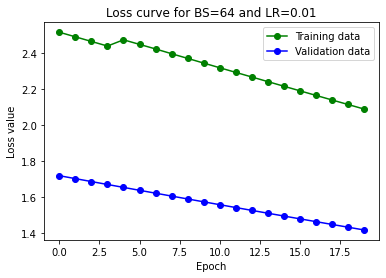

== Test Accuracy =  45.666666666666664  % ==


======= Logistic Regression with BS = 64 and LR = 0.001 =======
Epoch =  1  Training Loss =  0.9128357784953193
Epoch =  2  Training Loss =  0.9116165293034328
Epoch =  3  Training Loss =  0.9104012355732523
Epoch =  4  Training Loss =  0.9091899003369319
Epoch =  5  Training Loss =  0.9079825265706856
Epoch =  6  Training Loss =  0.9067791171943115
Epoch =  7  Training Loss =  0.9055796750707654
Epoch =  8  Training Loss =  0.904384203005703
Epoch =  9  Training Loss =  0.9031927037470376
Epoch =  10  Training Loss =  0.9020051799844807
Epoch =  11  Training Loss =  0.9008216343491056
Epoch =  12  Training Loss =  0.8996420694128842
Epoch =  13  Training Loss =  0.8984664876882441
Epoch =  14  Training Loss =  0.8972948916276149
Epoch =  15  Training Loss =  0.8961272836229757
Epoch =  16  Training Loss =  0.8949636660054082
Epoch =  17  Training Loss =  0.8938040410446404
Epoch =  18  Training Loss =  0.8926484109485904
Epoch =  19  Trai

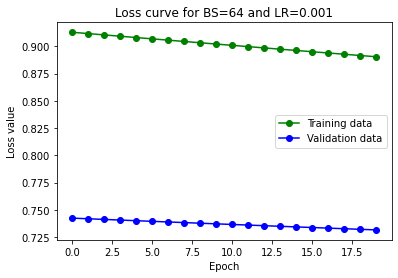

== Test Accuracy =  46.33333333333333  % ==


======= Logistic Regression with BS = 128 and LR = 0.1 =======
Epoch =  1  Training Loss =  2.411106106779518
Epoch =  2  Training Loss =  2.3874466750430283
Epoch =  3  Training Loss =  2.363693032811991
Epoch =  4  Training Loss =  2.340239851687906
Epoch =  5  Training Loss =  2.3166966314910367
Epoch =  6  Training Loss =  2.2933570966683328
Epoch =  7  Training Loss =  2.2700659269169448
Epoch =  8  Training Loss =  2.246922665118428
Epoch =  9  Training Loss =  2.223889442102579
Epoch =  10  Training Loss =  2.20097620840767
Epoch =  11  Training Loss =  2.1781855617084678
Epoch =  12  Training Loss =  2.1555121416623453
Epoch =  13  Training Loss =  2.1329734687431188
Epoch =  14  Training Loss =  2.1105603342463977
Epoch =  15  Training Loss =  2.088280340819371
Epoch =  16  Training Loss =  2.0661351601888214
Epoch =  17  Training Loss =  2.0441298289375576
Epoch =  18  Training Loss =  2.0222635708850216
Epoch =  19  Training Loss

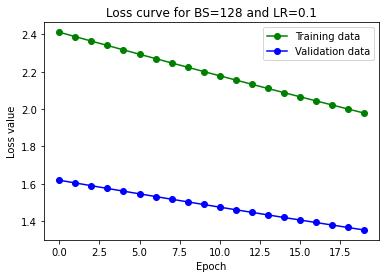

== Test Accuracy =  45.666666666666664  % ==


======= Logistic Regression with BS = 128 and LR = 0.01 =======
Epoch =  1  Training Loss =  2.266141524958128
Epoch =  2  Training Loss =  2.2638967584300933
Epoch =  3  Training Loss =  2.2615578605877418
Epoch =  4  Training Loss =  2.2592252490547287
Epoch =  5  Training Loss =  2.2569838865193947
Epoch =  6  Training Loss =  2.2546581742058622
Epoch =  7  Training Loss =  2.252337774995984
Epoch =  8  Training Loss =  2.2500223029871864
Epoch =  9  Training Loss =  2.2477114238744056
Epoch =  10  Training Loss =  2.2454757788047006
Epoch =  11  Training Loss =  2.243170351380213
Epoch =  12  Training Loss =  2.240868972044472
Epoch =  13  Training Loss =  2.2385714165564625
Epoch =  14  Training Loss =  2.2362774851908584
Epoch =  15  Training Loss =  2.2339870006727574
Epoch =  16  Training Loss =  2.2316998048960572
Epoch =  17  Training Loss =  2.2294157557348555
Epoch =  18  Training Loss =  2.227134725246751
Epoch =  19  Training

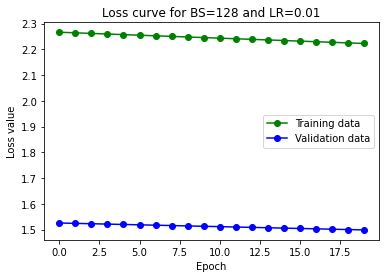

== Test Accuracy =  45.666666666666664  % ==


======= Logistic Regression with BS = 128 and LR = 0.001 =======
Epoch =  1  Training Loss =  2.995158141185584
Epoch =  2  Training Loss =  2.9949057401488384
Epoch =  3  Training Loss =  2.994653451762055
Epoch =  4  Training Loss =  2.9944012105749676
Epoch =  5  Training Loss =  2.994148773664343
Epoch =  6  Training Loss =  2.9938965535916795
Epoch =  7  Training Loss =  2.9936445505905125
Epoch =  8  Training Loss =  2.9933923528021755
Epoch =  9  Training Loss =  2.9931399094922315
Epoch =  10  Training Loss =  2.9928874601531326
Epoch =  11  Training Loss =  2.9926356994113754
Epoch =  12  Training Loss =  2.9923833398602544
Epoch =  13  Training Loss =  2.992131001052816
Epoch =  14  Training Loss =  2.9918789567147988
Epoch =  15  Training Loss =  2.991626662616254
Epoch =  16  Training Loss =  2.991374369974595
Epoch =  17  Training Loss =  2.991122281123288
Epoch =  18  Training Loss =  2.9908698176510624
Epoch =  19  Training 

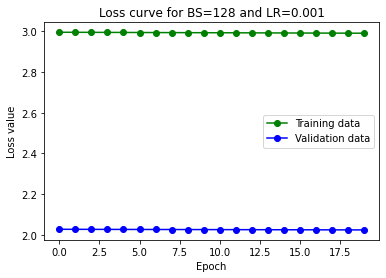

== Test Accuracy =  45.666666666666664  % ==




In [282]:
bs = [32, 64, 128]
lr = [0.1, 0.01, 0.001]

for i in bs:
    for j in lr:
        lr2 = LogisticRegression_SGD(lr = j, epoch =20, bs = i)

        lr2.fit(X_train, y_train, X_val, y_val)
        lr2.predict(X_test, y_test)

### Logistic Regression done with Batch size 64 and Learning rate = 0.01 
Got the best performance with test accuracy = 55.3%

### Overall Batch size 128 gave the least test accuracy

### In General, the models with higher Learning rate = 0.1 performed better in all batch sizes with less loss value

## 5) d) Logistic Regression with L2 Regularization

In [283]:
class LogisticRegression_L2:
    
    def __init__(self, lr, epoch, rc):
        self.lr = lr
        self.epoch = epoch
        self.rc = rc

    # Define sigmoid function
    def sigmoid(self, z):
        sig = 1/(1 + np.exp(-z))
        return sig
    
    def calculate_loss(self, X):
        loss = 0
        for i in range(len(X)):
            y_n = self.sigmoid(np.dot(self.w.T, X[i]) + self.b)
            
            if y_n ==0 or y_n == 1:
                continue
                    
            loss += (y[i]*np.log(y_n)) + ((1 - y[i])*np.log(1-y_n))
                
        loss = loss * (-1/X.shape[0])
        return loss
        
    
    # Performing Logistic Regression with L2 Regularization
    def fit(self, X, y, X_val, y_val):
        
        print("======= Logistic Regression with RC = "+str(self.rc)+" =======") 
        losses = []
        losses_val = []
        
        N = X.shape[0]
        
        # Initialize parameters
        self.w = np.random.rand(X.shape[1]) 
        self.b = 0
        
        for epoch in range(self.epoch):
            
            for i in range(len(X)):
                
                
                # Compute gradient w.r.t 'w' 
                grdw = 1/N * ((X[i] * (y[i] - self.sigmoid(np.dot(self.w.T, X[i]) + self.b))) + self.rc*self.w)

                # Compute gradient w.r.t 'b'
                grdb = 1/N * (y[i] - self.sigmoid(np.dot(self.w.T, X[i]) + self.b) + self.rc*self.b)
                
                # Update parameters
                self.w = self.w + self.lr * grdw
                self.b = self.b + self.lr * grdb
                
            
            loss = self.calculate_loss(X)
            #print("Epoch = ", epoch+1, " Training Loss = ", loss)
            losses.append(loss)

            loss = self.calculate_loss(X_val)
            #print("Epoch = ", epoch+1, " Validation Loss = ", loss)
            losses_val.append(loss)

        plt.plot([i for i in range(self.epoch)], losses, marker="o", color='g') 
        plt.plot([i for i in range(self.epoch)], losses_val, marker="o", color='b')
        plt.legend(['Training data', 'Validation data'])
        plt.xlabel('Epoch')
        plt.ylabel('Loss value')
        plt.title('Loss curve for RC='+str(self.rc))
        plt.show()
        
    def predict(self, X, y):
        predictions = []
        for i in range(len(X)):
            z = np.dot(self.w, X[i]) + self.b
            y_pred = self.sigmoid(z)
            if y_pred>=0.5:
                predictions.append(1)
            else:
                predictions.append(0)
        acc = 0
        for i in range(len(predictions)):
            if predictions[i] == y[i]:
                acc+=1
        print("== Test Accuracy = ",acc/len(X)*100," % ==\n\n")
        

======= Logistic Regression with RC = 0.01 =======


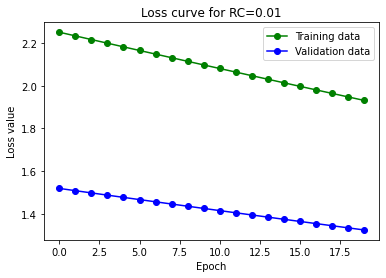

== Test Accuracy =  45.666666666666664  % ==


======= Logistic Regression with RC = 0.1 =======


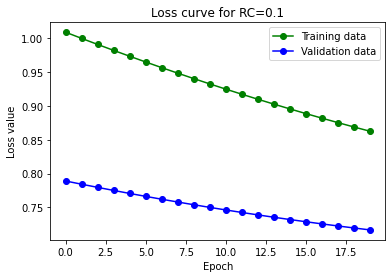

== Test Accuracy =  46.666666666666664  % ==


======= Logistic Regression with RC = 1 =======


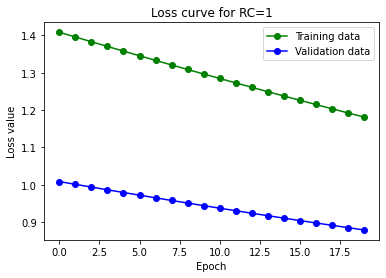

== Test Accuracy =  46.0  % ==




In [288]:
rc = [0.01, 0.1, 1]

for i in rc:
    lr2 = LogisticRegression_L2(lr = 0.001, epoch =20, rc = i)

    lr2.fit(X_train, y_train, X_val, y_val)
    lr2.predict(X_test, y_test)

### Overfitting - for Regularization Coefficient = 0.01
Both the training and validation loss values turned out to be larger than the other two cases. 
Test accuracy = 45.6% (Least out of all)

### Best fit - for Regularization Coefficient = 0.1
Both the training and validation loss values turned out to be minimal than the other two cases. 
Test accuracy = 46.6% (Best out of all)

### Under fit - for Regularization Coefficient = 1
The training and validation loss values increased compared to the previous case. Also, test accuracy got reduced.
Test accuracy = 46%
